In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import numpy as np
import time
from torch.optim.lr_scheduler import StepLR, LambdaLR
import sympy as sp

In [3]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [19]:
class Multi_Func(nn.Module):
    def __init__(self, functions, num_params, symbols, x_data, input_channels, device):
        super().__init__()
        self.device = device
        self.functions = functions
        self.x_data = x_data.to(self.device)
        self.input_channels = input_channels
        self.num_params = num_params
        self.max_params = max(num_params)
        self.total_params = sum(self.num_params)
        self.symbols = symbols

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.input_channels, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(64)
        )

        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.SELU(),
            nn.Linear(32, 20),
            nn.SELU(),
        )

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(4),
        )

        self.flatten_layer = nn.Flatten()

        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 128),
            nn.SELU(),
            nn.Linear(128, 64),
            nn.SELU(),
            nn.Linear(64, self.total_params),
        )

    def evaluate(self, params, index):
        symbols = self.symbols[index]
        formula = self.functions[index]
        x = self.x_data
        var_values = {str(symbols[j]): params[:, j] for j in range(len(symbols)-1)}
        eval_func = sp.lambdify(symbols, formula, modules="numpy")
        var_values[str(symbols[-1])] = x.unsqueeze(1)
        results = eval_func(**var_values)
        results = torch.nan_to_num(results, 0)
        return results.swapaxes(0,1)

    def forward(self, inputs):
        target = inputs.squeeze(dim=2)
        outs = torch.swapaxes(inputs, 1, 2).to(self.device)
        outs = self.hidden_x1(outs)
        xfc = torch.reshape(outs, (-1, 256))
        xfc = self.hidden_xfc(xfc)

        outs = torch.reshape(outs, (-1, 2, 128))
        outs = self.hidden_x2(outs)
        cnn_flat = self.flatten_layer(outs)
        encoded = torch.cat((cnn_flat, xfc), 1)
        embedding = self.hidden_embedding(encoded)

        loss_func = nn.MSELoss()
        start_index = 0
        losses = []
        outputs = []
        all_params = []
        
        for f in range(len(self.functions)):
            params = embedding[:, start_index:start_index+self.num_params[f]]
            all_params.append(params)
            output = self.evaluate(params, f).to(self.device)
            outputs.append(output)
            loss = loss_func(output, target)
            losses.append(loss)
            start_index += self.num_params[f]        
        best_index = torch.argmin(torch.tensor(losses))
        best_func = self.functions[best_index]
        best_loss, best_out = losses[best_index], outputs[best_index]

        return best_out, best_loss, best_func, outputs, losses

In [6]:
loaded_data = torch.load('hold_data.pth')

x_values = loaded_data['x_values'].to(device)
y_values = loaded_data['y_values'].to(device)
derivatives = loaded_data['derivatives'].to(device)
params = loaded_data['param_values'].to(device)
functions = loaded_data['formulas']
symbols = loaded_data['symbols']
num_params = loaded_data['num_params'].to(device)
function_labels = loaded_data['function_labels'].to(device)

/tmp/ipykernel_1052847/3483314352.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load('hold_data.pth')


In [7]:
print(f"x_values: {x_values.shape}")
print(f"y_values: {y_values.shape}")
print(f"derivatives: {derivatives.shape}")
#print(f"hessians: {hessians.shape}")
print(f"param_values: {params.shape}")
print(f"formulas: {len(functions)}")
print(f"symbols: {len(symbols)}")
print(f"num_params: {num_params.shape}")
print(f"function_labels: {function_labels.shape}")

x_values: torch.Size([100])
y_values: torch.Size([10000, 100])
derivatives: torch.Size([10000, 100, 5])
param_values: torch.Size([10000, 5])
formulas: 10
symbols: 10
num_params: torch.Size([10])
function_labels: torch.Size([10000])


In [30]:
input_data = y_values[0:2000, :].unsqueeze(2)
dataloader = DataLoader(input_data, batch_size=100, shuffle=True)

In [31]:
model = Multi_Func(functions, num_params, symbols, x_values, 1, device).to(device)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

epochs = 100
for epoch in range(epochs):
    start_time = time.time()
    train_loss = 0.0
    total_num = 0
    model.train()
    
    for train_batch in dataloader:
        train_batch = train_batch.to(device)
        optimizer.zero_grad()
        best_out,_,_,_,_ = model(train_batch)
        loss = loss_func(best_out,train_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * best_out.shape[0]
        total_num += best_out.shape[0]
    scheduler.step()
    train_loss /= total_num
    print(f"epoch : {epoch}/{epochs}, loss = {train_loss:.8f}")
    print(f"--- {time.time() - start_time} seconds ---")

/home/cymberly/FeynmanEquations/.conda/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([100, 100, 1])) that is different to the input size (torch.Size([100, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch : 0/100, loss = 0.37017665
--- 0.30831456184387207 seconds ---
epoch : 1/100, loss = 0.31653299
--- 0.26885437965393066 seconds ---
epoch : 2/100, loss = 0.32046123
--- 0.26534128189086914 seconds ---
epoch : 3/100, loss = 0.31604510
--- 0.26836395263671875 seconds ---
epoch : 4/100, loss = 0.31542729
--- 0.26635074615478516 seconds ---
epoch : 5/100, loss = 0.31340838
--- 0.2685544490814209 seconds ---
epoch : 6/100, loss = 0.31229532
--- 0.2673928737640381 seconds ---
epoch : 7/100, loss = 0.31334414
--- 0.26736974716186523 seconds ---
epoch : 8/100, loss = 0.31227798
--- 0.268723726272583 seconds ---
epoch : 9/100, loss = 0.31281350
--- 0.26793360710144043 seconds ---
epoch : 10/100, loss = 0.31233946
--- 0.26708555221557617 seconds ---
epoch : 11/100, loss = 0.31185169
--- 0.26750874519348145 seconds ---
epoch : 12/100, loss = 0.31188797
--- 0.2656702995300293 seconds ---
epoch : 13/100, loss = 0.31187131
--- 0.2669687271118164 seconds ---
epoch : 14/100, loss = 0.31189372
--

best_func: a*x**2/2
best_loss: 0.30405330657958984


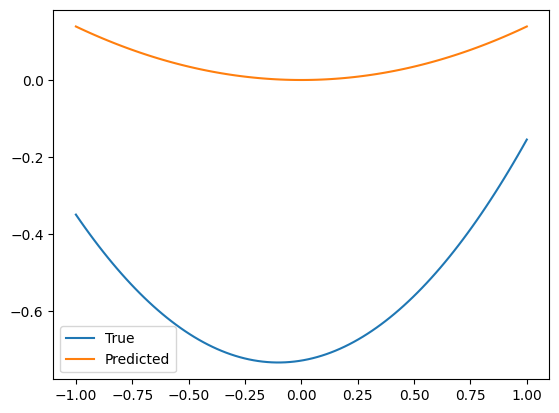

In [60]:
model.eval()
ran = np.random.randint(0, 100)
best_out, best_loss, best_func, outputs, losses = model(input_data)
print(f"best_func: {best_func}")
print(f"best_loss: {best_loss}")
plt.plot(x_values.detach().cpu().numpy(), y_values[ran].detach().cpu().numpy(), label='True')
plt.plot(x_values.detach().cpu().numpy(), best_out[ran][0:100].detach().cpu().numpy(), label='Predicted')
plt.legend()